# Homework 4 : Applied Machine Learning

In [149]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import sklearn.cluster
%matplotlib inline

In [150]:
# import data
df = pd.read_csv('CrowdstormingDataJuly1st.csv', index_col=0)
df.head()

,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
playerShort,,,,,,,,,,,,,,,,,,,,,
lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [151]:
df.isnull().sum()

player               0
club                 0
leagueCountry        0
birthday             0
height             263
weight            2243
position         17726
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID          21407
rater1           21407
rater2           21407
refNum               0
refCountry           0
Alpha_3              1
meanIAT            163
nIAT               163
seIAT              163
meanExp            163
nExp               163
seExp              163
dtype: int64

We can see that we still have missing values in these fields:
* height
* weight
* position
* photoID
* rater1
* rater2
* meanIAT
* nIAT
* meanExp
* nExp
* seExp

IAT and Exp features are exogenous to the players, we won't include it in the player description for Part.1 
rater1 and rater2 missing entries come from the missing photos, we can simply drop the corresponding lines.
Weight and height was dropped as well as it corresponded to only 24 unique players (in the worst case) out of 1585.
The missing position was handled by the dummy encoding of this variable

In [152]:
# drop rows for which we have no photo (and thus no skin rating)
df.dropna(subset=['rater1', 'rater2', 'weight', 'height'], inplace=True)

# group by players
group_by_players = df.groupby(level=0)

# build the data used for later analysis

# for league country, keep only the one that appears the most for one player
player_description = group_by_players.agg({'leagueCountry': lambda x: x.value_counts().index[0],
                                           'position': 'first',
                                           'height': 'mean', 
                                           'weight': 'mean',
                                           'games': 'sum',
                                           'victories': 'sum',
                                           'ties': 'sum',
                                           'defeats': 'sum',
                                           'goals': 'sum',
                                           'yellowCards': 'sum',
                                           'yellowReds': 'sum',
                                           'redCards': 'sum',
                                           'rater1': 'first',
                                           'rater2': 'first'
                                          })

# dummy encoding of the categorical variables with handling of missing values
player_description = pd.get_dummies(player_description, dummy_na= True, columns = ['leagueCountry', 'position'])
player_description.head()

,ties,rater2,rater1,defeats,goals,games,weight,victories,redCards,height,...,position_Center Midfielder,position_Defensive Midfielder,position_Goalkeeper,position_Left Fullback,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger,position_nan
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,179,0.00,0.25,228,9,654,71.0,247,0,182.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-hunt,73,0.25,0.00,122,62,336,73.0,141,1,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-lennon,97,0.25,0.25,115,31,412,63.0,200,0,165.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
aaron-ramsey,42,0.00,0.00,68,39,260,76.0,150,1,178.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abdelhamid-el-kaoutari,40,0.25,0.25,43,1,124,73.0,41,2,180.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
# labels
player_rating = player_description['rater1']

player_description.drop(['rater1', 'rater2'], axis=1, inplace=True)


## Training the classifier

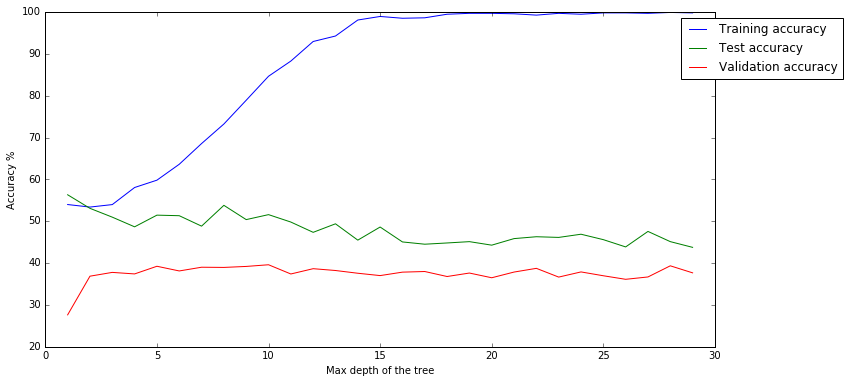

In [154]:
import warnings
warnings.filterwarnings('ignore')

X = player_description.as_matrix()
y = (player_rating*4).as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
tr_accuracy = []
te_accuracy = []
cross = []
for n in [20]:
    for d in range(1,30):
        model = RandomForestClassifier(n_estimators=n, max_depth=d)
        c = sklearn.cross_validation.cross_val_score(model, X, y, cv=20, scoring='f1_weighted')
        cross.append(np.mean(c)*100)
        model.fit(X_train, y_train)

        te_pred = model.predict(X_test)
        tr_pred = model.predict(X_train)

        tr_acc = sklearn.metrics.f1_score(tr_pred, y_train, average='weighted')*100

        te_acc = sklearn.metrics.f1_score(te_pred, y_test, average='weighted')*100

        tr_accuracy.append(tr_acc)
        te_accuracy.append(te_acc)
plt.figure(figsize=(12,6))    
plt.plot(range(1,30), tr_accuracy, label='Training accuracy')
plt.plot(range(1,30), te_accuracy, label='Test accuracy');
plt.plot(range(1,30), cross, label='Validation accuracy');
plt.ylabel('Accuracy %')
plt.xlabel('Max depth of the tree')
plt.legend(bbox_to_anchor=(1.2, 1));

### Effect of the parameters on the classifier
Several parameters were tried for the classifier, only the max depth of the tree is shown above. As we can see using cross-validation mitigated the over-fitting effect

### Feature Importance

In [155]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

col = player_description.columns

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, col[indices[f]], importances[indices[f]]))


1. feature victories (0.102189)
2. feature games (0.096787)
3. feature goals (0.093810)
4. feature yellowCards (0.093580)
5. feature weight (0.092289)
6. feature defeats (0.091809)
7. feature height (0.091559)
8. feature ties (0.089797)
9. feature yellowReds (0.041995)
10. feature redCards (0.041113)
11. feature leagueCountry_France (0.020728)
12. feature leagueCountry_Spain (0.011990)
13. feature position_Center Forward (0.011875)
14. feature leagueCountry_England (0.011405)
15. feature leagueCountry_Germany (0.010695)
16. feature position_Defensive Midfielder (0.010547)
17. feature position_nan (0.010240)
18. feature position_Center Back (0.009904)
19. feature position_Right Fullback (0.009627)
20. feature position_Right Winger (0.009477)
21. feature position_Attacking Midfielder (0.009077)
22. feature position_Left Fullback (0.008699)
23. feature position_Goalkeeper (0.007807)
24. feature position_Right Midfielder (0.007497)
25. feature position_Left Midfielder (0.006182)
26. featur

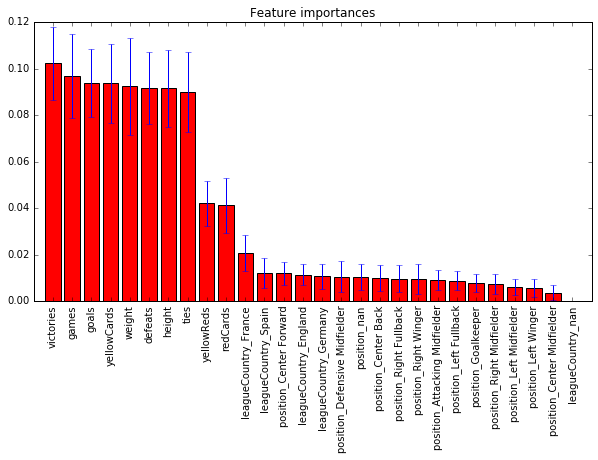

In [156]:
# Plot the feature importances of the forest
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices],  align='center')
plt.xticks(range(X.shape[1]), col[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

We can see that 8 features seem to emerge from the rest. In that order: weight, defeats, victories, yellow cards, games, height, ties and goals are the most important. Ties and yellow reds follow while the league country and the position seem to be non informative

### Experiments with different features
We try to fit the model with different subsets of the data and see the evolution of the feature importance ranking

In [157]:
subset_cols = col[indices[0:8]]
player_description_subset = player_description[list(subset_cols)]

X_subset = player_description_subset.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3)


model2 = RandomForestClassifier(n_estimators=20, max_depth=10)
model2.fit(X_train, y_train)

te_pred = model2.predict(X_test)
tr_pred = model2.predict(X_train)

tr_acc = tr_pred == y_train
tr_acc = np.sum(tr_acc)/len(tr_acc) * 100

te_acc = te_pred == y_test
te_acc = np.sum(te_acc)/len(te_acc) * 100
print('Training accuracy: %.2f, Test accuracy: %.2f' % (tr_acc, te_acc))

Training accuracy: 75.78, Test accuracy: 39.15


In [158]:
player_description_subset.head()

,victories,games,goals,yellowCards,weight,defeats,height,ties
playerShort,,,,,,,,
aaron-hughes,247,654,9,19,71.0,228,182.0,179
aaron-hunt,141,336,62,42,73.0,122,183.0,73
aaron-lennon,200,412,31,11,63.0,115,165.0,97
aaron-ramsey,150,260,39,31,76.0,68,178.0,42
abdelhamid-el-kaoutari,41,124,1,8,73.0,43,180.0,40


In [159]:
importances = model2.feature_importances_
std = np.std([tree.feature_importances_ for tree in model2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

col = player_description_subset.columns

for f in range(X_subset.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, col[indices[f]], importances[indices[f]]))


1. feature victories (0.132322)
2. feature yellowCards (0.129314)
3. feature height (0.126061)
4. feature games (0.125425)
5. feature goals (0.125186)
6. feature ties (0.123282)
7. feature weight (0.121288)
8. feature defeats (0.117122)


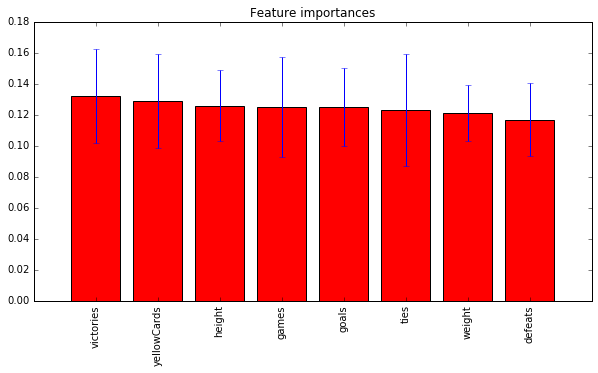

In [160]:
# Plot the feature importances of the forest
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X_subset.shape[1]), importances[indices],
       color="r", yerr=std[indices],  align='center')
plt.xticks(range(X_subset.shape[1]), col[indices], rotation=90)
plt.xlim([-1, X_subset.shape[1]])
plt.show()

Observations.
* by keeping only subsets of the 8 relevant features, we see that the exact ordering of the feature importance changes but the relative difference of importance is negligible. Thus we can conclude that there is not substantial difference in the feature importance.

### Unsupervised learning : Data processing

In [201]:
basic = df[['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']]
basic.dropna(subset=['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'], inplace=True)


ref_basic = basic.groupby(level=0).mean()
ref_basic.drop(['nIAT', 'nExp'], axis=1, inplace=True)

df2 = df[['rater1', 'rater2']].groupby(df.index).first()
df2['skin'] = df2.apply(lambda x: (x['rater1'] + x['rater2'])/2, axis=1)
skin = df2['skin'] > 0.5

In [202]:
import warnings
warnings.filterwarnings('ignore')

df1 = df[['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']]
df1.dropna(subset=['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'], inplace=True)

df1['mIAT'] = df1.apply(lambda x: x.loc['meanIAT']*x.loc['nIAT'], axis=1)
df1['sIAT'] = df1.apply(lambda x: x.loc['seIAT']*x.loc['nIAT'], axis=1)
df1['mExp'] = df1.apply(lambda x: x.loc['meanExp']*x.loc['nExp'], axis=1)
df1['sExp'] = df1.apply(lambda x: x.loc['seExp']*x.loc['nExp'], axis=1)

group_player = df1.groupby(df1.index)

ref = group_player.agg({'nIAT': 'sum',
                        'mIAT': 'sum',
                        'sIAT': 'sum',
                        'nExp': 'sum',
                        'mExp': 'sum',
                        'sExp': 'sum'     
    })

ref['mIAT'] = ref['mIAT']/ref['nIAT']
ref['mExp'] = ref['mExp']/ref['nExp']

ref['sIAT'] = ref['sIAT']/ref['nExp']
ref['sExp'] = ref['sExp']/ref['nExp']

ref.drop(['nIAT', 'nExp'], axis=1, inplace=True)

In [203]:
def cluster(ref, col):

    sil = []
    f1 = []
    feature = []
    
    for i in col:
        for j in i:
            kMean = sklearn.cluster.KMeans(n_clusters=2, init='k-means++', n_init=10).fit(ref[list(j)])
            silhouette = sklearn.metrics.silhouette_score(ref[list(j)], kMean.labels_)
            f1_score = max(sklearn.metrics.f1_score(skin, kMean.labels_, average='weighted'), sklearn.metrics.f1_score(~skin, kMean.labels_, average='weighted'))
            sil.append(silhouette)
            f1.append(f1_score)
            feature.append(j)
            
    return sil, f1, feature

In [204]:
import itertools
col = []
for r in range(1,5):
    col.append(list(itertools.combinations(ref.columns, r)))
    
col1 = []
for r in range(1,5):
    col1.append(list(itertools.combinations(ref_basic.columns, r)))

sil_basic, f1_basic, feature_basic = cluster(ref_basic, col1)
sil, f1, feature = cluster(ref, col)

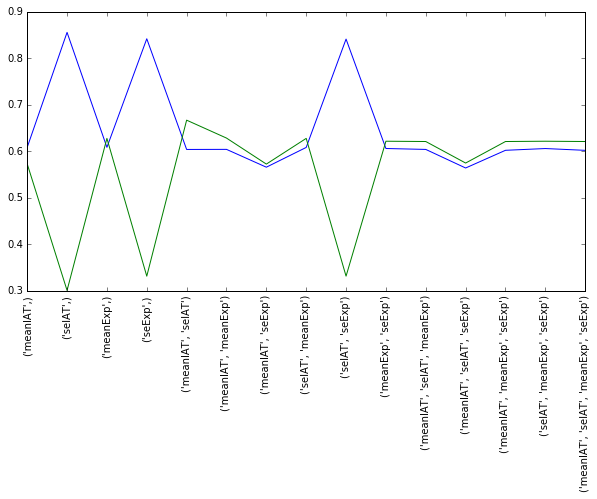

In [205]:
plt.figure(figsize=(10,5))
plt.plot(range(15), sil_basic)
plt.plot(range(15), f1_basic)
plt.xticks(range(15),feature_basic, rotation='vertical');

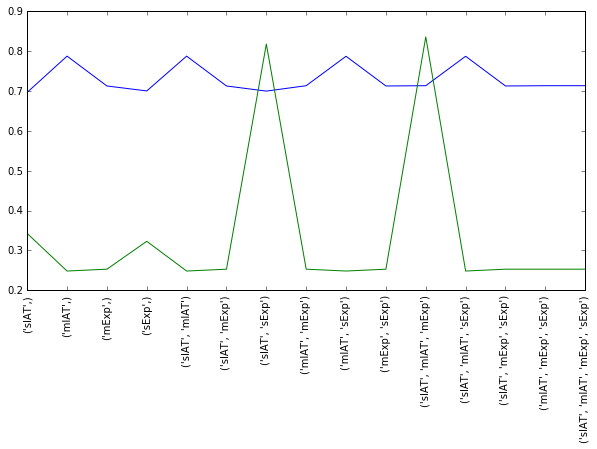

In [206]:
plt.figure(figsize=(10,5))
plt.plot(range(15), sil)
plt.plot(range(15), f1)
plt.xticks(range(15),feature, rotation='vertical');

playerShort
aaron-hughes               True
aaron-hunt                 True
aaron-lennon               True
aaron-ramsey               True
abdelhamid-el-kaoutari     True
abdou-traore_2            False
abdoulaye-diallo_2        False
abdoulaye-keita_2         False
abdoulwhaid-sissoko       False
abdul-rahman-baba         False
abdul-razak               False
abel-aguilar               True
abelaziz-barrada           True
abou-diaby                False
adam-bodzek                True
adam-federici              True
adam-hlousek               True
adam-johnson               True
adam-pinter                True
adam-smith_3               True
adam-szalai                True
adan                       True
adel-taarabt               True
adil-rami                  True
adrian-colunga             True
adrian-mutu                True
adrian_2                   True
adrian_7                   True
adriano_24                 True
adrien-rabiot              True
                          ..